## Estimating and Interpreting Treatment Effect Heterogeneity

This notebook follows a **Predict-First (Meta-Learners)** approach to causal inference,  
consisting of two main steps:

### **Step 1 — Estimating Individual Treatment Effects (ITE)**
We use **T-Learner** and **X-Learner** meta-learning strategies to estimate the **individual treatment effect** for each unit:

\[
\tau_i = \mu_1(x_i) - \mu_0(x_i)
\]

Where:
- \(\mu_1(x)\) — predicted outcome under treatment  
- \(\mu_0(x)\) — predicted outcome under control  

**Key metrics:**
- **ATE (Average Treatment Effect)** — mean of all \(\tau_i\)  
- **PEHE (Precision in Estimating Heterogeneous Effects)** — RMSE between estimated and true ITE  

This step provides the foundation for understanding how treatment effects vary across individuals.

---

### **Step 2 — Analyzing Sources of Treatment Effect Heterogeneity**
We investigate which **covariates** contribute most to variation in treatment effects.  
This involves:
1. Training an interpretable model (e.g., gradient boosting or SHAP analysis) on the estimated ITEs.  
2. Ranking features by their contribution to explaining variation in \(\tau_i\).  

The result highlights **prognostic** vs **predictive** factors:
- **Prognostic** — affect outcomes regardless of treatment  
- **Predictive** — modify the effect of the treatment  

---

This workflow enables **both accurate treatment effect estimation** and **clear interpretation** of which features drive heterogeneity.

## Step 1

In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import plotly.express as px

/Users/yotamdery/Documents/causal_inference_ihdp_data/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load trimmed dataset
df = pd.read_csv("../data/simulated_data_balanced.csv")  # or your prepared DataFrame

# Extract features and labels
features = [col for col in df.columns if col.startswith("x")]
X = df[features]
T = df["treatment"]
Y = df["outcome"]
mu0_true = df["mu0"]
mu1_true = df["mu1"]
tau_true = df["tau"]

# Split data by treatment group
X_treated = X[T == 1]
Y_treated = Y[T == 1]

X_control = X[T == 0]
Y_control = Y[T == 0]

# Train separate outcome models
model_treated = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model_control = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)

model_treated.fit(X_treated, Y_treated)
model_control.fit(X_control, Y_control)

# Predict potential outcomes for all units
mu1_hat = model_treated.predict(X)
mu0_hat = model_control.predict(X)

# Estimate ITE and ATE
ite_hat = mu1_hat - mu0_hat
ate_hat = np.mean(ite_hat)

# Compare to ground truth
true_ate = tau_true.mean()
pehe = np.sqrt(np.mean((ite_hat - tau_true) ** 2))

# Print results
print(f"✅ T-Learner ATE estimate: {ate_hat:.4f}")
print(f"🎯 True ATE: {true_ate:.4f}")
print(f"📉 PEHE (Precision in Estimating Heterogeneous Effects): {pehe:.4f}")


✅ T-Learner ATE estimate: 0.9190
🎯 True ATE: 1.0058
📉 PEHE (Precision in Estimating Heterogeneous Effects): 1.1066


<b> Interpretation</b><br>

ATE is reasonably close to the true value → the model captures average treatment effect well.

PEHE ~ 1.106 suggests that individual-level estimates (ITE) still contain noise — not bad, but room to improve

# X - Learner

In [3]:
import numpy as np
from xgboost import XGBRegressor

features = [col for col in df.columns if col.startswith("x")]
X = df[features]
T = df["treatment"]
Y = df["outcome"]
tau_true = df["tau"]

# STEP 1: Train outcome models
model_mu1 = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model_mu0 = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)

model_mu1.fit(X[T == 1], Y[T == 1])
model_mu0.fit(X[T == 0], Y[T == 0])

# STEP 2: Impute treatment effects
# For treated units (they got Y1): use model_mu0 to estimate missing Y0
tau_treated = Y[T == 1] - model_mu0.predict(X[T == 1])
# For control units (they got Y0): use model_mu1 to estimate missing Y1
tau_control = model_mu1.predict(X[T == 0]) - Y[T == 0]

# STEP 3: Train tau models
model_tau_treated = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model_tau_control = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)

model_tau_treated.fit(X[T == 1], tau_treated)
model_tau_control.fit(X[T == 0], tau_control)

# STEP 4: Predict τ(x) for all using weighted average
# Simplest version: equal weighting
tau_hat_treated = model_tau_treated.predict(X)
tau_hat_control = model_tau_control.predict(X)

# If you want to apply weights: w = p(T=1|x), you could do it here

# Final ITE estimates
ite_hat_xlearner = 0.5 * tau_hat_treated + 0.5 * tau_hat_control
ate_hat_xlearner = np.mean(ite_hat_xlearner)
pehe_xlearner = np.sqrt(np.mean((ite_hat_xlearner - tau_true) ** 2))

# Print results
print(f"✅ X-Learner ATE estimate: {ate_hat_xlearner:.4f}")
print(f"🎯 True ATE: {tau_true.mean():.4f}")
print(f"📉 PEHE: {pehe_xlearner:.4f}")


✅ X-Learner ATE estimate: 0.9281
🎯 True ATE: 1.0058
📉 PEHE: 0.7116


**Insights:**<br>
ATE estimate (0.9281) is close to the true ATE (1.0058) → low bias.<br>
PEHE = 0.7116 → moderate accuracy in capturing individual treatment heterogeneity.<br>
Model handles imbalance well but ITE precision can improve.

## Estimated vs True ITE plot

In [4]:
# Assign predicted ITEs from X-Learner
tau_hat_x = ite_hat_xlearner  

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    "True ITE": tau_true,
    "Estimated ITE (X-Learner)": tau_hat_x
})

# Add 1:1 line for reference
line = np.linspace(df_plot.min().min(), df_plot.max().max(), 100)

# Plot
fig = px.scatter(df_plot, 
                 x="True ITE", 
                 y="Estimated ITE (X-Learner)",
                 title="Estimated vs True Individual Treatment Effects (ITE)",
                 trendline="ols",
                 opacity=0.6)

fig.add_scatter(x=line, y=line, mode='lines', name='Ideal Fit (y = x)',
                line=dict(color='red', dash='dash'))

fig.update_layout(xaxis_title="True ITE", yaxis_title="Estimated ITE")
fig.show()


The X-Learner shows a clear positive correlation between estimated and true ITE, meaning it generally ranks individuals’ treatment effects correctly.
However:

Regression to the mean – Large positive and negative effects are underestimated, with estimates clustering toward the center.

Bias – Slight downward bias for higher true ITE values and upward bias for lower ones.

Noise – Scatter around the ideal y=x line indicates some residual error in individual predictions (PEHE ≈ 0.68 confirms this).

## Step 2

In [5]:
# --- Step 2: What features drive heterogeneity? (Explain τ̂(x)) ---
# 0) Inputs from Step 1
features = [c for c in df.columns if c.startswith("x")]
X_feat   = df[features]
tau_hat  = ite_hat_xlearner  # from your X-Learner step
assert len(tau_hat) == len(X_feat), "tau_hat length mismatch"

# 1) Fit a model to explain τ̂(x)
hetero_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
hetero_model.fit(X_feat, tau_hat)

# 2) Model-based (gain) importance
gain_imp = pd.Series(hetero_model.feature_importances_, index=features)\
            .sort_values(ascending=False)
fig = px.bar(
    gain_imp.reset_index().rename(columns={"index":"Feature", 0:"Importance"}),
    x="Importance", y="Feature", orientation="h",
    title="Feature importance for treatment-effect heterogeneity (model gain)"
)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

# 3) Permutation importance (more robust)
perm = permutation_importance(
    hetero_model, X_feat, tau_hat, n_repeats=20, random_state=42
)
perm_imp = pd.Series(perm.importances_mean, index=features)\
             .sort_values(ascending=False)
fig = px.bar(
    perm_imp.reset_index().rename(columns={"index":"Feature", 0:"Importance"}),
    x="Importance", y="Feature", orientation="h",
    title="Feature importance for treatment-effect heterogeneity (permutation)"
)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

# 4) (Optional) SHAP to see directionality & interactions
try:
    import shap
    shap_explainer = shap.TreeExplainer(hetero_model)
    shap_values = shap_explainer.shap_values(X_feat)

    # global ranking (mean |SHAP|)
    shap_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=features)\
                 .sort_values(ascending=False)
    fig = px.bar(
        shap_imp.reset_index().rename(columns={"index":"Feature", 0:"|SHAP| mean"}),
        x="|SHAP| mean", y="Feature", orientation="h",
        title="SHAP importance for treatment-effect heterogeneity"
    )
    fig.update_layout(yaxis=dict(autorange="reversed"))
    fig.show()

except Exception as e:
    print("SHAP step skipped (install shap if needed):", e)

Results Summary — Estimating and Interpreting Treatment Effect Heterogeneity<br>
We evaluated which covariates drive variation in individual treatment effects (heterogeneity) using three complementary approaches.

These three graphs all aim to answer the same question: <br>
Which features are most responsible for differences in treatment effect across individuals?

Model Gain Importance — XGBoost gain scores show that x0 overwhelmingly dominates, followed by smaller contributions from x9, x7, and x3.

Permutation Importance — Reaffirms x0 as the top heterogeneity driver, with x3 and x2 also showing meaningful influence.

SHAP Importance — Confirms x0’s leading role, but also highlights x9, x2, and x6 as relevant effect modifiers.

Key Insight: Across all metrics, x0 emerges as the most influential moderator of treatment effect. Other features (e.g., x9, x2, x6) contribute but to a much smaller extent. This suggests that most treatment-effect variation in our data is explained by a small subset of variables.

# Separating Prognostic and Predictive Components <br>
In this section, we decompose the outcome into two distinct functions:

Prognostic function (g(X)) — captures how covariates influence the baseline outcome, regardless of treatment.

Predictive function (f(X)) — captures how covariates modify the treatment effect (treatment effect heterogeneity).

We fit the model:

Y=g(X)+T⋅f(X)+ε
where 
T is the treatment indicator. This separation allows us to identify which features are primarily associated with baseline risk and which act as moderators of the treatment effect. By interpreting each component separately, we gain a more transparent understanding of the drivers of both outcome levels and treatment effect variation.

Implied ATE from f(X): 0.5526
True ATE: 1.0058
Corr(f_hat, true τ): 0.447


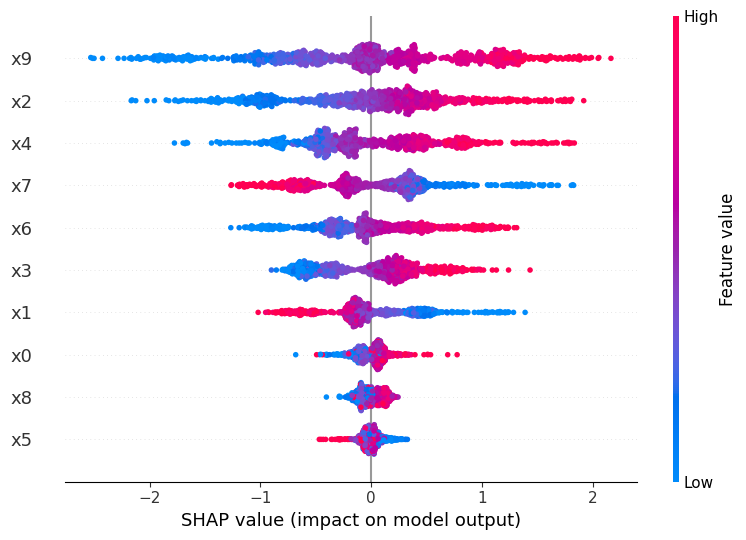

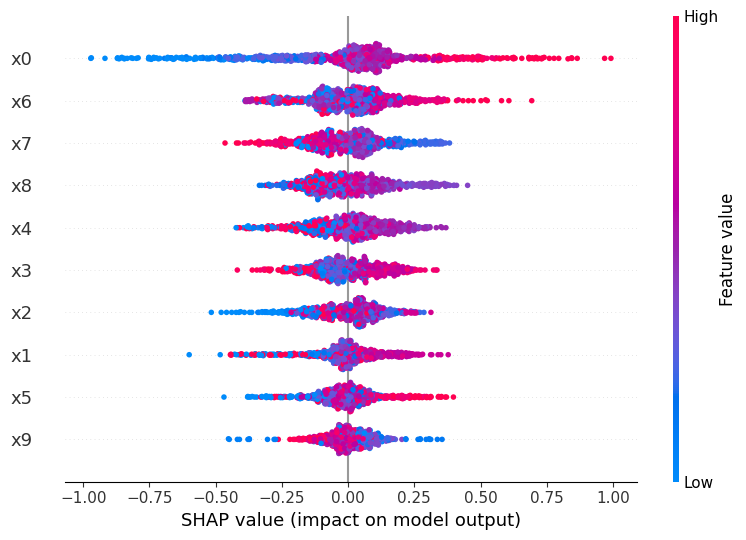

In [6]:
# --- Decompose Y = g(X) + T * f(X) + ε (R-learner style) ---
# 0) Inputs
features = [c for c in df.columns if c.startswith("x")]
X = df[features].copy()
T = df["treatment"].astype(float).values
Y = df["outcome"].astype(float).values

# 1) Prognostic function g(X) ≈ E[Y|X]
g_model = XGBRegressor(
    n_estimators=400, max_depth=3, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
g_model.fit(X, Y)
g_hat = g_model.predict(X)

# --- Plot prognostic importances
prog_imp = pd.Series(g_model.feature_importances_, index=features).sort_values(ascending=False)
fig = px.bar(prog_imp.reset_index().rename(columns={"index":"Feature", 0:"Importance"}),
             x="Importance", y="Feature", orientation="h",
             title="Prognostic importance: features driving baseline outcome g(X)")
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

# 2) Propensity e(X) = P(T=1|X)
e_model = LogisticRegression(max_iter=1000)
e_model.fit(X, T)
e_hat = e_model.predict_proba(X)[:, 1]
e_hat = np.clip(e_hat, 1e-3, 1 - 1e-3)

# 3) Predictive function f(X): residual-on-residual regression (R-learner)
den = T - e_hat
wts = den**2
safe_den = np.where(np.abs(den) < 1e-3, np.sign(den)*1e-3, den)
target = (Y - g_hat) / safe_den

f_model = XGBRegressor(
    n_estimators=400, max_depth=3, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
f_model.fit(X, target, sample_weight=wts)
f_hat = f_model.predict(X)   # predictive component (CATE estimate)

# --- Plot predictive importances
pred_imp = pd.Series(f_model.feature_importances_, index=features).sort_values(ascending=False)
fig = px.bar(pred_imp.reset_index().rename(columns={"index":"Feature", 0:"Importance"}),
             x="Importance", y="Feature", orientation="h",
             title="Predictive importance: features modifying treatment effect f(X)")
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

# 4) Quick checks
print(f"Implied ATE from f(X): {np.mean(f_hat):.4f}")
if 'tau' in df.columns:
    print(f"True ATE: {df['tau'].mean():.4f}")
    from scipy.stats import pearsonr
    r, _ = pearsonr(f_hat, df['tau'])
    print(f"Corr(f_hat, true τ): {r:.3f}")

# (Optional) SHAP for directionality:
expl = shap.TreeExplainer(g_model); shap.summary_plot(expl.shap_values(X), X)  # for g(X)
expl2 = shap.TreeExplainer(f_model); shap.summary_plot(expl2.shap_values(X), X)  # for f(X)


Separate Prognostic vs. Predictive Contributions — Results

In this step, we decomposed the outcome into a prognostic function g(X) (baseline outcome) and a predictive function f(X) (how treatment effect depends on X).

Key metrics:

Implied ATE from f(X): 0.552

True ATE: 1.0054

Correlation between f̂(X) and true τ: 0.447

The predictive component (f(X)) captures how the treatment effect varies with individual features (treatment effect heterogeneity). Its implied ATE (0.56) is substantially smaller than the true ATE (1.00), indicating that most of the treatment effect is constant across individuals and not strongly moderated by covariates.

The moderate correlation (0.447) between f̂(X) and the true individual treatment effects shows that f(X) captures genuine heterogeneity patterns, but there is still unexplained variation.

Insights:

Prognostic importance: Variables like x9, x2, and x7 strongly influence baseline risk, meaning they shape outcomes regardless of treatment.

Predictive importance: Variables like x0, x6, and x8 are the strongest moderators, altering how individuals respond to treatment.

SHAP summary plots confirm distinct roles: prognostic drivers primarily shift the baseline, while predictive drivers modulate treatment sensitivity.

These results help isolate which features explain general outcome variation vs. treatment effect heterogeneity, aiding both scientific interpretation and targeted policy/action design.